In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
import gc

In [2]:
import dask_geopandas

In [3]:
panel_rent_per_sf_per_neighborhood = pd.read_csv('../data/panel_rent_per_sf_per_neighborhood.csv', index_col=0)
panel = gpd.read_feather('../data/panel_data_estimated_costs.geofeather')

In [4]:
neigh = gpd.read_file('../data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp')
sf = neigh[neigh.CITY.str.contains('San Francisco')]

sf_neighborhoods = sf[['NAME', 'geometry']]

sf_neighborhoods = sf_neighborhoods.rename(columns={'NAME': 'zillow_neighborhood_name'})

sf_neighborhoods = sf_neighborhoods.replace({'zillow_neighborhood_name': {
    'Marina' : 'Marina District',
    'Haight-Ashbury': 'Haight',
    'South Of Market': 'South of Market',
    'Ocean View': 'Oceanview',
    'Castro-Upper Market': 'Castro',
    'Twin Peaks': 'Clarendon Heights',
    'West Of Twin Peaks': 'Forest Knolls'
}})

In [5]:
type(panel)

geopandas.geodataframe.GeoDataFrame

In [6]:
dask_df = dask_geopandas.from_geopandas(panel, npartitions=10)

In [7]:
dask_df = dask_df.to_crs(epsg=3310)

In [8]:
panel = dask_df.compute()

In [9]:
del dask_df

In [10]:
gc.collect()

30

In [11]:
sf_neighborhoods = sf_neighborhoods.to_crs(panel.crs)

In [12]:
panel_df = panel.sjoin_nearest(sf_neighborhoods, how='left')

In [13]:
panel_df = panel_df.drop_duplicates(('MapBlkLot_Master', 'year'))

In [14]:
panel_df = pd.merge(panel_df, panel_rent_per_sf_per_neighborhood, how='left')

In [15]:
dask_df = dask_geopandas.from_geopandas(panel_df, npartitions=10)

<Axes: >

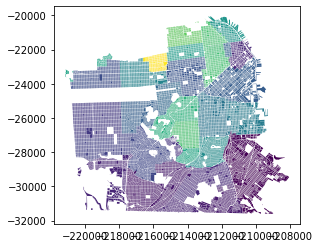

In [16]:
dask_df.query('closed_roll_year == 2016').compute().plot(column='rent/sf')

In [17]:
dask_df = dask_df.map_partitions(lambda geodf: geodf[geodf['geometry'].notna()])

In [18]:
dask_df['x'] = dask_df['geometry'].map_partitions(lambda geometry: geometry.representative_point().x, 
                                                  meta=('x', float))
dask_df['y'] = dask_df['geometry'].map_partitions(lambda geometry: geometry.representative_point().y, 
                                                  meta=('y', float))

In [19]:
panel_df = dask_df.compute()

In [20]:
for year in range(int(panel_df.year.min()), int(panel_df.year.max() + 1)):
    time_slice = panel_df[panel_df.year == year]
    space = time_slice[['x', 'y', 'rent/sf', 'home_size1']]
    result = KNNImputer().fit_transform(space)
    panel_df.loc[time_slice.index, ['rent/sf', 'home_size1']] = result[:, 2:]

<Axes: >

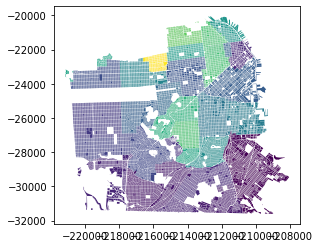

In [21]:
panel_df.query('closed_roll_year == 2016').plot(column='rent/sf')

In [22]:
panel_df = panel_df.drop(columns=['index_right'])

### Unit count data

In [23]:
homes = pd.read_excel('../data/Housing Production 2005-2022.xlsx')

In [24]:
dbi = gpd.read_feather('../data/dbi_permits.geofeather')

In [25]:
date_cols = [c for c in dbi.columns if 'date' in c]
dbi[date_cols] = dbi[date_cols].apply(lambda x: pd.to_datetime(x, errors='coerce'))
cost_cols = [c for c in dbi.columns if 'cost' in c]
dbi[cost_cols] = dbi[cost_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
unit_cols = [c for c in dbi.columns if 'unit' in c]
dbi[unit_cols] = dbi[unit_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [26]:
dbi = dbi.sort_values('permit_creation_date', ascending=False)
dbi = dbi.drop_duplicates('permit_number')

# NB: 5 rows in homes don't match-
permits = pd.merge(dbi[['geometry', 'permit_number', 'permit_creation_date']],
                   homes,
                   left_on='permit_number', right_on='BPA', how='inner')
permits = permits[['geometry', 'permit_number', 'Permit Issued Date', 'permit_creation_date',
                   'Net_Units_Completed', 'Date_Completed', 'BlockLot']]


In [27]:
permits = permits[permits['Net_Units_Completed'] > 0]

In [28]:
df_list = []

for year in range(2007, 2017):
    parcels_year = panel_df[panel_df.year == year].copy()
    permits_year = permits[permits['permit_creation_date'].dt.year == year].copy()
    df_list.append(gpd.sjoin(parcels_year, permits_year.to_crs(panel_df.crs), how='left', predicate='contains'))

In [29]:
panel_df.Developed.sum()

341

In [30]:
result = pd.concat(df_list, axis=0)

In [31]:
nuc_agg = result.groupby(['MapBlkLot_Master', 'year']).agg({'Net_Units_Completed': 'sum'}).reset_index()

In [32]:
result = result.drop_duplicates(['MapBlkLot_Master', 'year'])

In [33]:
result = pd.merge(result.drop(columns='Net_Units_Completed'), nuc_agg, on=['MapBlkLot_Master', 'year'])

In [34]:
result.shape

(1530794, 75)

In [35]:
result = result.drop(columns='index_right')

In [36]:
#panel_df_pois = gpd.sjoin(result, permits.to_crs(panel_df.crs), how='left', predicate='contains')

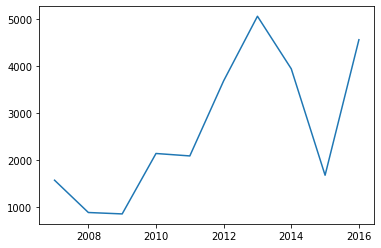

In [37]:
plt.plot(result.groupby('year').agg({'Net_Units_Completed': 'sum'}))

In [38]:
result.Developed = result.permit_number.notna()

In [39]:
result.Developed.sum()

1831

### Fires

In [40]:
fires = gpd.read_feather('../data/clean_accidental_fires.geofeather')

In [41]:
fires.to_crs(result.crs, inplace=True)

In [42]:
panel_fires = gpd.sjoin(result,
                        fires[['geometry',
                               'estimated_property_loss',
                               'incident_date']].rename(columns= 
                                                        {'estimated_property_loss' : 'fire_damage', 
                                                         'incident_date': 'fire_date'}), 
                        how='left',
                        predicate='contains')

In [43]:
panel_fires.index_right.notna().sum()

3479

In [44]:
panel_fires = panel_fires.drop(columns=['index_right'])

In [45]:
panel_fires.fire_damage.fillna(0, inplace=True)

In [46]:
panel_fires['years_since_fire'] = panel_fires.year - panel_fires.fire_date.dt.year

In [47]:
panel_fires['years_since_fire'][panel_fires['years_since_fire'].notna()]

51         -1.0
160        -7.0
472       -16.0
560       -13.0
735         0.0
           ... 
1529737    -1.0
1529747    -1.0
1529797    -6.0
1529875    -6.0
1530254    -6.0
Name: years_since_fire, Length: 3479, dtype: float64

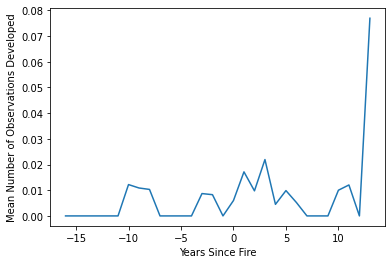

In [48]:
# Compute the mean for each unique value of 'years_since_fire'
plot_data = panel_fires.groupby('years_since_fire')['Developed'].mean().reset_index()

# Plot using seaborn
sns.lineplot(x='years_since_fire', y='Developed', data=plot_data)
plt.ylabel('Mean Number of Observations Developed')
plt.xlabel('Years Since Fire')
plt.show()

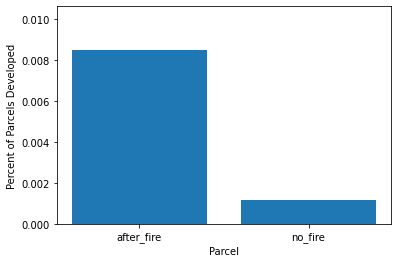

In [49]:
panel_fires['fire_category'] = np.where(panel_fires['years_since_fire'].fillna(-1) < 0, 'no_fire', 'after_fire')

# Compute the mean for each category
plot_data = panel_fires.groupby('fire_category')['Developed'].mean().reset_index()

# Plot using matplotlib
plt.bar(plot_data['fire_category'], plot_data['Developed'])

# Set y-axis limit to 110% of the maximum value
plt.ylim(0, plot_data['Developed'].max() * 1.25)

plt.ylabel('Percent of Parcels Developed')
plt.xlabel('Parcel')
plt.show()

### Revenue & Cost

In [50]:
panel_fires['revenue'] = panel_fires['rent/sf'] * panel_fires['Envelope_1000'] * 1000

In [51]:
panel_fires['costs'] = (panel_fires['construction_cost_est'] 
                        + np.maximum(panel_fires['assessed_improvement_value'] - panel_fires['fire_damage'], 0)
                        + panel_fires['imputed_land_value'])

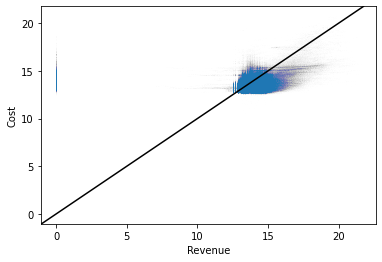

In [52]:
f, ax = plt.subplots()
plt.scatter(np.log1p(panel_fires['revenue']), np.log1p(panel_fires['costs']), alpha=.01, s=.01)
plt.xlabel('Revenue')
plt.ylabel('Cost')
ax.axline((0, 0), slope=1, color='black')
plt.show()


In [53]:
(panel_fires['costs'] < 50000).mean()

6.530514153909851e-07

In [54]:
panel_fires['fire_damage'].max()

13200000.0

In [55]:
panel_fires['revenue'].max()

2273240062.457

(0.0, 100.0)

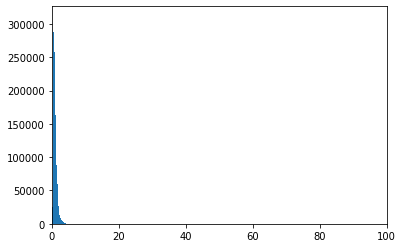

In [56]:
plt.hist(np.log1p(panel_fires['revenue'] / panel_fires['costs']), bins=40)
plt.xlim(0, 100)

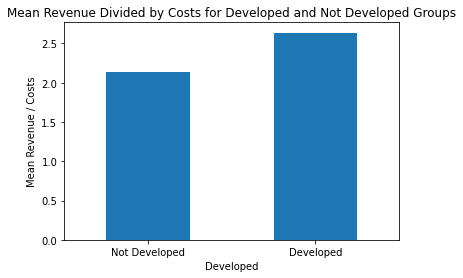

In [57]:
result = panel_fires.groupby('Developed').apply(lambda x: (x['revenue'] / x['costs']).mean())

# Create the bar plot
result.plot(kind='bar', ylabel='Mean Revenue / Costs', title='Mean Revenue Divided by Costs for Developed and Not Developed Groups')
plt.xticks(ticks=[0, 1], labels=['Not Developed', 'Developed'], rotation=0)
plt.show()

In [58]:
panel_fires.to_csv('./panel_fires.csv', index=False)